In [1]:
import os
import torch
from dataloader import MRDataset
from tqdm import tqdm
from tqdm import tqdm_notebook
from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, ToTensor, Compose, RandomAffine
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
import cv2
import pdb
import model

In [2]:
import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd

import pdb

from torch.autograd import Variable

class MRDataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
            array = self.transform(array)
            array = array.numpy()
            
        array = np.stack((array,)*3, axis=1)
        array = torch.FloatTensor(array)
        
        
        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight



dataset = MRDataset('/home/niamh/Documents/MRNET/data/', 
                    'acl',
                   'sagittal',
                    transform=None, 
                    train=False)
loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=1, 
                                     shuffle=False, 
                                     num_workers=0, 
                                     drop_last=False)




In [ ]:
train_dataset = MRDataset('/home/niamh/Documents/MRNET/data/', 
                    'acl',
                   'sagittal',
                         train =True, transform=None)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=1, drop_last=False)




m =torch.load('/home/niamh/Documents/MRNET/resnet18_tuple1/models/model_res_tuple1_acl_sagittal_val_auc_0.9529_train_auc_0.9997_epoch_25.pth')


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

m._modules.get('pretrained_model').layer4.register_forward_hook(hook_feature);

features_blobs_gr = []

def backward_hook(module, grad_in, grad_out):
    print(grad_out)
    features_blobs_gr.append(grad_out[0].cpu().numpy() )
    
m._modules.get('pretrained_model').layer4.register_backward_hook(backward_hook);


for i, (image,label, weight) in enumerate(train_loader):
      #  optimizer.zero_grad()
    label = label[0]
    weight = weight[0]
    a = np.zeros((1,1))
    prediction = m.forward(image.float())
    b = label.numpy()
    c = pd.concat([pd.DataFrame(a), pd.DataFrame(b)], axis =1)
    c.columns = ['dud', 'target']
    c['dud'] = 1 - c['target']
    label = torch.from_numpy(np.asarray(c))
    loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
    loss.backward()
    #    optimizer.step()
    break




In [17]:
gcam.shape

torch.Size([38, 256, 256])

/home/niamh/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/niamh/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/niamh/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/niamh/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


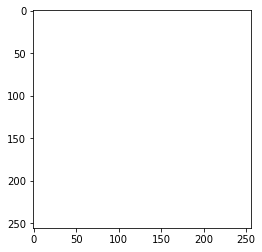

In [4]:
weights =nn.AdaptiveAvgPool2d(1)(torch.Tensor(features_blobs_gr[0]))
gcam = torch.mul(torch.Tensor(features_blobs[0]), weights).sum(dim=1, keepdim=True)
gcam = F.relu(gcam)
gcam = F.interpolate(
            gcam, (256,256), mode="bilinear", align_corners=False
        )
B, C, H, W = gcam.shape


gcam = gcam.view(B, -1)
gcam -= gcam.min(dim=1, keepdim=True)[0]
gcam /= gcam.max(dim=1, keepdim=True)[0]
gcam = gcam.view(B, H, W)


import matplotlib.pyplot as plt 
plt.imshow(gcam.numpy()[0])

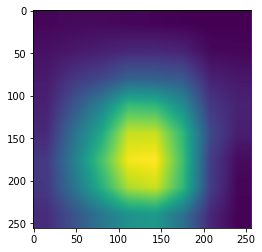

In [18]:
plt.imshow(gcam.numpy()[15])

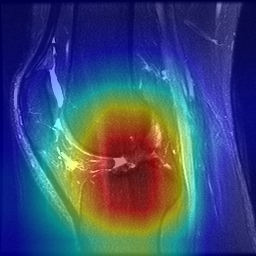

In [19]:

img = image[0][15].numpy()
img = img.transpose(1, 2, 0)
heatmap = np.uint8(255 * gcam.numpy()[15])

heatmap = (cv2
            .cvtColor(cv2.applyColorMap(
                cv2.resize(heatmap, (256, 256)),
                cv2.COLORMAP_JET), 
                       cv2.COLOR_BGR2RGB)
          )
result = heatmap * 0.5 + img * 0.5  

pil_img_cam = Image.fromarray(np.uint8(result))
pil_img_cam

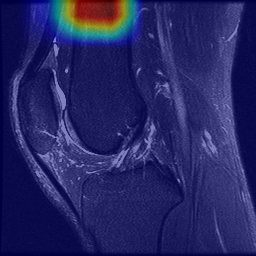

In [20]:

img = image[0][17].numpy()
img = img.transpose(1, 2, 0)
heatmap = np.uint8(255 * gcam.numpy()[17])

heatmap = (cv2
            .cvtColor(cv2.applyColorMap(
                cv2.resize(heatmap, (256, 256)),
                cv2.COLORMAP_JET), 
                       cv2.COLOR_BGR2RGB)
          )
result = heatmap * 0.5 + img * 0.5  

pil_img_cam = Image.fromarray(np.uint8(result))
pil_img_cam

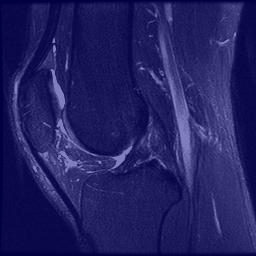

In [21]:

img = image[0][16].numpy()
img = img.transpose(1, 2, 0)
heatmap = np.uint8(255 * gcam.numpy()[16])

heatmap = (cv2
            .cvtColor(cv2.applyColorMap(
                cv2.resize(heatmap, (256, 256)),
                cv2.COLORMAP_JET), 
                       cv2.COLOR_BGR2RGB)
          )
result = heatmap * 0.5 + img * 0.5  

pil_img_cam = Image.fromarray(np.uint8(result))
pil_img_cam

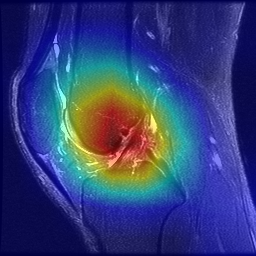

In [22]:

img = image[0][18].numpy()
img = img.transpose(1, 2, 0)
heatmap = np.uint8(255 * gcam.numpy()[18])

heatmap = (cv2
            .cvtColor(cv2.applyColorMap(
                cv2.resize(heatmap, (256, 256)),
                cv2.COLORMAP_JET), 
                       cv2.COLOR_BGR2RGB)
          )
result = heatmap * 0.5 + img * 0.5  

pil_img_cam = Image.fromarray(np.uint8(result))
pil_img_cam

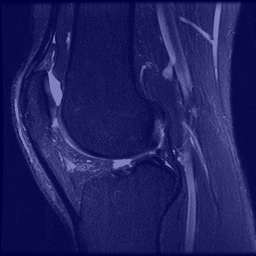

In [23]:

img = image[0][14].numpy()
img = img.transpose(1, 2, 0)
heatmap = np.uint8(255 * gcam.numpy()[14])

heatmap = (cv2
            .cvtColor(cv2.applyColorMap(
                cv2.resize(heatmap, (256, 256)),
                cv2.COLORMAP_JET), 
                       cv2.COLOR_BGR2RGB)
          )
result = heatmap * 0.5 + img * 0.5  

pil_img_cam = Image.fromarray(np.uint8(result))
pil_img_cam